In [1]:
using Random, LargeMessageCollider, Flux.Optimise, Distributions, Plots

┌ Info: Precompiling LargeMessageCollider [7f03d5f0-357e-4842-abc9-7001c0bc8a0e]
└ @ Base loading.jl:1278
┌ Warning: Package LargeMessageCollider does not have Random in its dependencies:
│ - If you have LargeMessageCollider checked out for development and have
│   added Random as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with LargeMessageCollider
└ Loading Random into LargeMessageCollider from project dependency, future warnings for LargeMessageCollider are suppressed.


In [97]:
Random.seed!(123);

In [98]:
# Synthetic Data
N = 4
inputs = [-5., -0.2, 15., 6.]
perturbations = rand(Normal(0,2),N)
sensor_inputs = inputs .+ perturbations
sensor_outputs = zeros(N)
for n=1:N
    sensor_outputs[n] = rand(truncated(Normal(sensor_inputs[n],0.5), 0., 10.))
end

In [99]:
# initial messages
w_forw = Gamma(5,1) # Prior for w
x_back = [] # Initial backward messages from f_x
for n=1:N
    push!(x_back,Gamma(0.01,100))
end

In [100]:
m_fx = w_forw
for n=1:N
    m_fx = collide(m_fx,x_back[n])
end

In [101]:
m_fx

Gamma{Float64}(α=1.0399999999999994, θ=0.9615384615384615)

In [102]:
# Inference
evmp = EVMP(100)
q_x = []
q_w = w_forw
for iter=1:10
    # Inference for x
    for i=1:N
        # Calculate the message towards fx_i
        m_fx = w_forw
        for n=1:N
            if n != i
                m_fx = collide(m_fx,x_back[n])
            end
        end
        # Calculate the forward message towards x_i
        mx_forw = normal(nothing,inputs[i],m_fx)
        if iter == 1 push!(q_x,mx_forw) end
        log_mx_back(x) = logpdf(truncated(Normal(x,0.5), 0., 10.),sensor_outputs[i])
        # EVMP
        q_x[i] = approximateMarginal!(evmp,nothing,log_mx_back,mx_forw)
        x_back[i] = normal(q_x[i],inputs[i],nothing)
    end
    # Inference for w
    q_w = w_forw
    for n=1:N
        q_w = collide(q_w,x_back[n])
    end
end

In [103]:
q_x

4-element Array{Any,1}:
 SampleList(
samples: Any[-5.394449171439069, -6.2523388525513335, -5.778747189263537, -5.947699027613913, -3.5368005526698445, -6.201390817473282, -4.760839906645233, -3.7902045893266294, -6.029689132248986, -4.699809675903996  …  -6.129660839539461, -4.398474773491383, -5.998588348155331, -6.128424893065719, -5.304561120102035, -4.956079654432247, -6.748077322774789, -4.8005144962349835, -5.255416466000977, -3.5743895484807293]
weights: [0.009977754247472194, 0.009102492491715302, 0.009600563071251587, 0.009426316436869553, 0.011052563178334196, 0.009157377537791413, 0.010516904891784607, 0.011016593839499772, 0.009340267272913547, 0.010561709591113496  …  0.009234192215126434, 0.010759934054051113, 0.00937301332154974, 0.009235510819164225, 0.010061312113136222, 0.010364277890015436, 0.008557931366574607, 0.010487009483484832, 0.010106130808332796, 0.011050281409999738]
num_samples: 100
dimension: 1
)

 SampleList(
samples: Any[-2.9443119349921427, 2.12384787

In [104]:
q_w

Gamma{Float64}(α=7.0, θ=0.09770735279754092)

In [105]:
mean(q_w)

0.6839514695827864

In [106]:
sensor_inputs

4-element Array{Float64,1}:
 -2.6194642380274464
  3.8963594155784795
 17.2853018057344
  6.918831240814161

In [107]:
mean(q_x[1])

-5.189758812099538

In [108]:
var(q_x[1])

0.7382085882927386

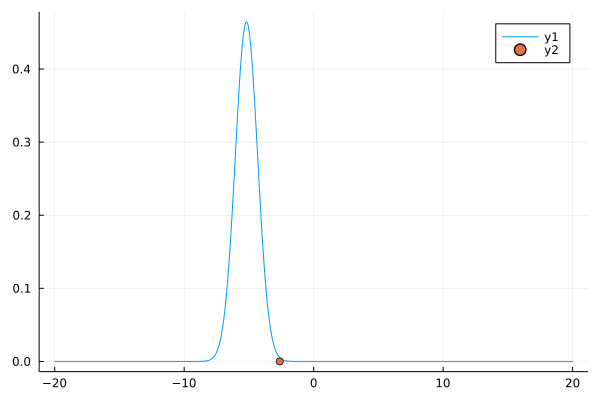

In [109]:
x_ax = collect(-20:0.01:20)
plot(x_ax,pdf.(Normal(mean(q_x[1]),sqrt(var(q_x[1]))),x_ax))
scatter!((sensor_inputs[1],0))

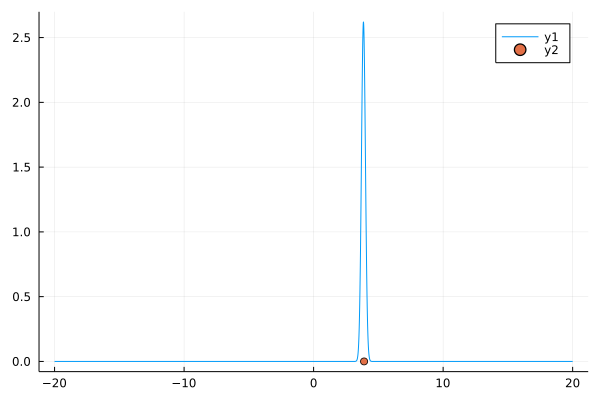

In [110]:
x_ax = collect(-20:0.01:20)
plot(x_ax,pdf.(Normal(mean(q_x[2]),sqrt(var(q_x[2]))),x_ax))
scatter!((sensor_inputs[2],0))

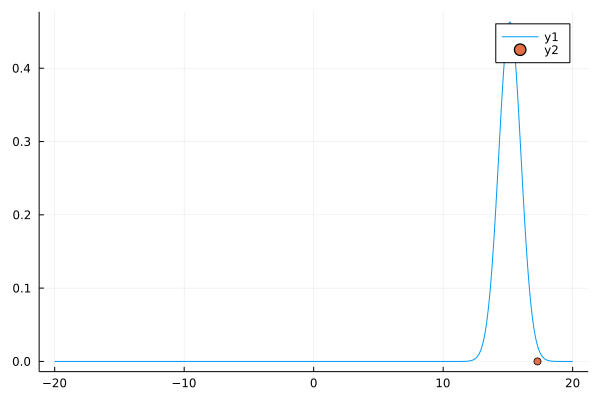

In [111]:
x_ax = collect(-20:0.01:20)
plot(x_ax,pdf.(Normal(mean(q_x[3]),sqrt(var(q_x[3]))),x_ax))
scatter!((sensor_inputs[3],0))

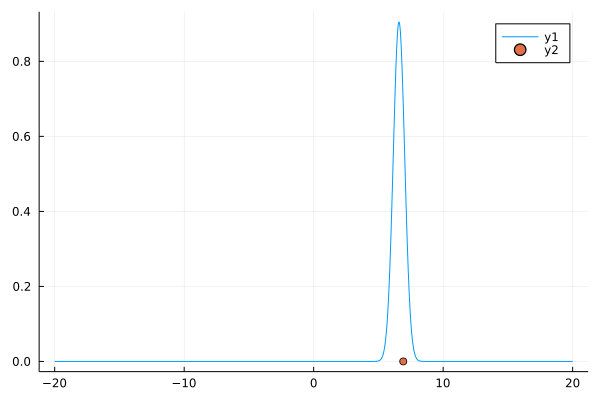

In [112]:
x_ax = collect(-20:0.01:20)
plot(x_ax,pdf.(Normal(mean(q_x[4]),sqrt(var(q_x[4]))),x_ax))
scatter!((sensor_inputs[4],0))